# Warp raster and shapefile
The dem raster and shape file are currently in NAD83 geographic coordinates (EPSG:4269).  For modflow we need to flatten the world and have things in flat, meter coordinates.  So, we need to project the coordinates.  Probably the best for this area is NAD83 UTM Zone 12N (EPSG:26912).  If this is all greek to you check out [this reading on projection etc.](https://pro.arcgis.com/en/pro-app/3.1/help/mapping/properties/coordinate-systems-and-projections.htm).

So here, we'll project our raster and shapefiles to NAD38:UTM12N


In [1]:
# use gdal to reproject the raster to NAD83 UTM zone 12N in python, but don't keep no data
from osgeo import gdal

# Open the raster file
dataset = gdal.Open("data/gis/RattlesnakeDEM.tif")

# Get the projection information
projection = dataset.GetProjection()

# Reproject the raster to NAD83 UTM zone 12N
reprojected_dataset = gdal.Warp("data/gis/RattlesnakeDEM_UTM12N.tif",\
     dataset, dstSRS="EPSG:26912",srcNodata=0, dstNodata=0)

# Close the datasets
dataset = None
reprojected_dataset = None


## Plot 
Here we check out the original and reprojected raster.

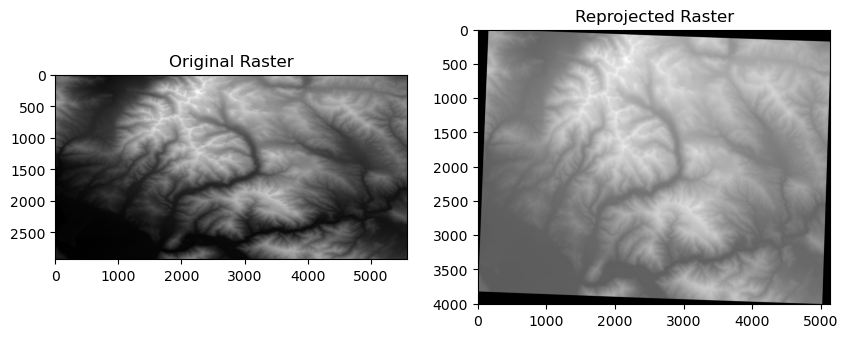

In [2]:

#plot the original and reprojected raster
import matplotlib.pyplot as plt

# Open the original raster file
original_dataset = gdal.Open("data/gis/RattlesnakeDEM.tif")

# Open the reprojected raster file
reprojected_dataset = gdal.Open("data/gis/RattlesnakeDEM_UTM12N.tif")

# Get the original raster data
original_raster = original_dataset.ReadAsArray()

# Get the reprojected raster data
reprojected_raster = reprojected_dataset.ReadAsArray()

# Plot the original and reprojected raster
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_raster, cmap='gray')
axes[0].set_title('Original Raster')
axes[1].imshow(reprojected_raster, cmap='gray')
axes[1].set_title('Reprojected Raster')

# Show the plot
plt.show()

# Close the datasets
original_dataset = None
reprojected_dataset = None

## Reproject the shape files
Now we need to ge the shape files in the same projection.

In [4]:
# reproject a shapefile to NAD83 UTM zone 12N in python using gdal
from osgeo import ogr, osr
import os

# Define the input shapefile
input_shapefile_path = os.path.join("data", "gis", "RattlesnakeWatershed.shp")
output_shapefile_path = os.path.join("data", "gis", "RattlesnakeWatershed_UTM12N.shp")

# Open the input shapefile
input_shapefile = ogr.Open(input_shapefile_path)
input_layer = input_shapefile.GetLayer()

# Get the spatial reference of the input shapefile
input_spatial_ref = input_layer.GetSpatialRef()

# Define the target spatial reference (NAD83 UTM zone 12N)
target_spatial_ref = osr.SpatialReference()
target_spatial_ref.SetWellKnownGeogCS("NAD83")
target_spatial_ref.SetUTM(12, 1)  # UTM zone 12N

# Create the output shapefile
output_shapefile = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(output_shapefile_path)
output_layer = output_shapefile.CreateLayer("reprojected_shapefile", target_spatial_ref, input_layer.GetGeomType())

# Add attributes to the new layer
feature_defn = input_layer.GetLayerDefn()
for i in range(feature_defn.GetFieldCount()):
    field_defn = feature_defn.GetFieldDefn(i)
    output_layer.CreateField(field_defn)

# Reproject and copy features with attributes
transform = osr.CoordinateTransformation(input_spatial_ref, target_spatial_ref)
for feature in input_layer:
    geometry = feature.GetGeometryRef()
    geometry.Transform(transform)
    new_feature = ogr.Feature(output_layer.GetLayerDefn())
    new_feature.SetGeometry(geometry)
    for i in range(feature_defn.GetFieldCount()):
        new_feature.SetField(i, feature.GetField(i))
    output_layer.CreateFeature(new_feature)
    new_feature = None  # Dereference the feature
    
# Close the shapefiles
input_shapefile = None
output_shapefile = None


Warning 1: Value 55001100378649 of field NHDPlusID of feature 0 not successfully written. Possibly due to too larger number with respect to field width
